# Restaurant Analysis in Charlotte, NC
## Shyam Sridharan

### Import Necessary Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup
import geocoder

print('Libraries imported.')

Libraries imported.


### Obtain scraped data for Charlotte Neighborhoods

In [2]:
char = requests.get("https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Charlotte,_North_Carolina").text
html_soup = BeautifulSoup(char, 'html.parser')

html_list = []
for row in html_soup.find_all("div", class_="mw-category")[0].findAll("li"):
    html_list.append(row.text)
    
charlotte1 = pd.DataFrame({"Neighborhood": html_list})
charlotte1['Neighborhood'] = charlotte1['Neighborhood'].map(lambda x: x.replace("(Charlotte neighborhood)","").replace(", Charlotte","").replace("(Charlotte, North Carolina)", "").replace(", North Carolina","").replace("(Charlotte)",""))
charlotte2 = charlotte1[1:]
charlotte2

,Neighborhood
1,The Arboretum
2,Ballantyne
3,Biddleville
4,Brooklyn
5,Chantilly
6,Uptown Charlotte
7,Cotswold
8,Coulwood
9,Derita
10,Dilworth


### Obtain Latitude and Longitude coordinates for each neighborhood

In [3]:
def charlotte_coords(neighborhood):
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Charlotte, North Carolina'.format(neighborhood))
        lat_lng_coords = g.latlng
        
    return lat_lng_coords



In [4]:
char_lng = []
char_lat = []
locator = Nominatim(user_agent="myGeocoder")
for i in range(len(charlotte2)):
    location = locator.geocode("{}, Charlotte, NC".format(charlotte2["Neighborhood"].iloc[i]))
    char_lat.append(location.latitude)
    char_lng.append(location.longitude)
    
char_lat

[35.09726725,
 35.0546593,
 35.2450426,
 35.2242765,
 35.2137544,
 35.2271902,
 35.1759242,
 35.30420915,
 35.2865023,
 35.2095873,
 35.2088208,
 35.2151174,
 35.3866225,
 35.2412292,
 35.1917349,
 35.246994,
 35.2204054,
 35.1582874,
 35.263798,
 35.2202706,
 35.1186739,
 35.192921,
 35.1709339,
 35.2126229,
 35.1484341,
 35.1382582,
 35.14409795,
 35.1570316,
 35.3171141]

In [5]:
len(char_lng)

29

In [6]:
#charlotte2.shape
# Only use each insert once

charlotte2.insert(1, "Latitude", char_lat, True) 
charlotte2.insert(2, "Longitude", char_lng, True) 
charlotte2

,Neighborhood,Latitude,Longitude
1,The Arboretum,35.097267,-80.781769
2,Ballantyne,35.054659,-80.850246
3,Biddleville,35.245043,-80.857348
4,Brooklyn,35.224277,-80.825737
5,Chantilly,35.213754,-80.810071
6,Uptown Charlotte,35.227190,-80.843083
7,Cotswold,35.175924,-80.798330
8,Coulwood,35.304209,-80.936693
9,Derita,35.286502,-80.811617
10,Dilworth,35.209587,-80.847572


### Create a map of Charlotte with points for each neighborhood

In [7]:
address = 'Charlotte, NC'

geolocator = Nominatim(user_agent="charlotte")
location1 = geolocator.geocode(address)
latitude1 = location1.latitude
longitude1 = location1.longitude
print('The geograpical coordinate of Charlotte are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinate of Charlotte are 35.2272086, -80.8430827.


In [8]:
map_charlotte = folium.Map(location=[latitude1, longitude1], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(charlotte2['Latitude'], charlotte2['Longitude'], charlotte2['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_charlotte)  
    
map_charlotte

### Set Foursquare API credentials and create method to obatain Restaurant Venues

In [9]:
CLIENT_ID = 'YBP5C51DAROYLGZZWVGY5MBYTPLPKQUL3JINB34WFRRHU3FW' # your Foursquare ID
CLIENT_SECRET = '0NDHDUDOCFQFXTIBDBXVBO5NYJZSEZOEFKNHMTWQSBLZK2DC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YBP5C51DAROYLGZZWVGY5MBYTPLPKQUL3JINB34WFRRHU3FW
CLIENT_SECRET:0NDHDUDOCFQFXTIBDBXVBO5NYJZSEZOEFKNHMTWQSBLZK2DC


In [10]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=750
    LIMIT=200
    categoryId='4d4b7105d754a06374d81259'
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood_Latitude', 
                  'Neighborhood_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

### Get Venues and then one hot encode dataframe for Venue Categories

In [11]:
Charlotte_venues = getNearbyVenues(names=charlotte2['Neighborhood'],
                                   latitudes=charlotte2['Latitude'],
                                   longitudes=charlotte2['Longitude']
                                  )

The Arboretum
Ballantyne 
Biddleville 
Brooklyn 
Chantilly 
Uptown Charlotte
Cotswold 
Coulwood 
Derita 
Dilworth 
Eastland 
Elizabeth 
Highland Creek 
Mountain Island
Myers Park 
NoDa 
North Charlotte 
Parkdale 
Paw Creek 
Plaza-Midwood 
Quail Hollow 
Sedgefield 
Sherwood Forest 
South End 
SouthPark 
Starmount 
Steele Creek 
Stonehaven 
University City 


In [12]:
Charlotte_venues.head()

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,The Arboretum,35.097267,-80.781769,Cajun Yard Dog,35.096891,-80.780155,Cajun / Creole Restaurant
1,The Arboretum,35.097267,-80.781769,Chick-fil-A,35.098873,-80.781388,Fast Food Restaurant
2,The Arboretum,35.097267,-80.781769,Noodles & Company,35.098528,-80.780533,Noodle House
3,The Arboretum,35.097267,-80.781769,McAlister's Deli,35.097407,-80.778803,Deli / Bodega
4,The Arboretum,35.097267,-80.781769,Manhattan Bagel,35.096958,-80.778843,Bagel Shop


In [13]:
Charlotte_venues.shape

(481, 7)

In [14]:
Charlotte_venues.Venue_Category.unique()

array(['Cajun / Creole Restaurant', 'Fast Food Restaurant',
       'Noodle House', 'Deli / Bodega', 'Bagel Shop',
       'Italian Restaurant', 'Salad Place',
       'Southern / Soul Food Restaurant', 'Sandwich Place', 'Bakery',
       'Asian Restaurant', 'Breakfast Spot', 'Burger Joint',
       'American Restaurant', 'Mexican Restaurant', 'Greek Restaurant',
       'Tex-Mex Restaurant', 'Café', 'Diner', 'Pizza Place',
       'Sushi Restaurant', 'BBQ Joint', 'Thai Restaurant',
       'Chinese Restaurant', 'Hot Dog Joint', 'Indian Restaurant',
       'Food Truck', 'Taco Place', 'Ramen Restaurant', 'Wings Joint',
       'Restaurant', 'Fried Chicken Joint', 'Mediterranean Restaurant',
       'Food', 'Seafood Restaurant', 'Food Stand', 'Gastropub',
       'Caribbean Restaurant', 'Vietnamese Restaurant',
       'Tapas Restaurant', 'Steakhouse', 'New American Restaurant',
       'Creperie', 'Irish Pub', 'Burrito Place', 'Bistro',
       'French Restaurant', 'Japanese Restaurant',
       'Midd

In [15]:
Charlotte_counts = pd.value_counts(Charlotte_venues['Venue_Category'].values, sort=True)

### Plot value counts for different Venue Categories

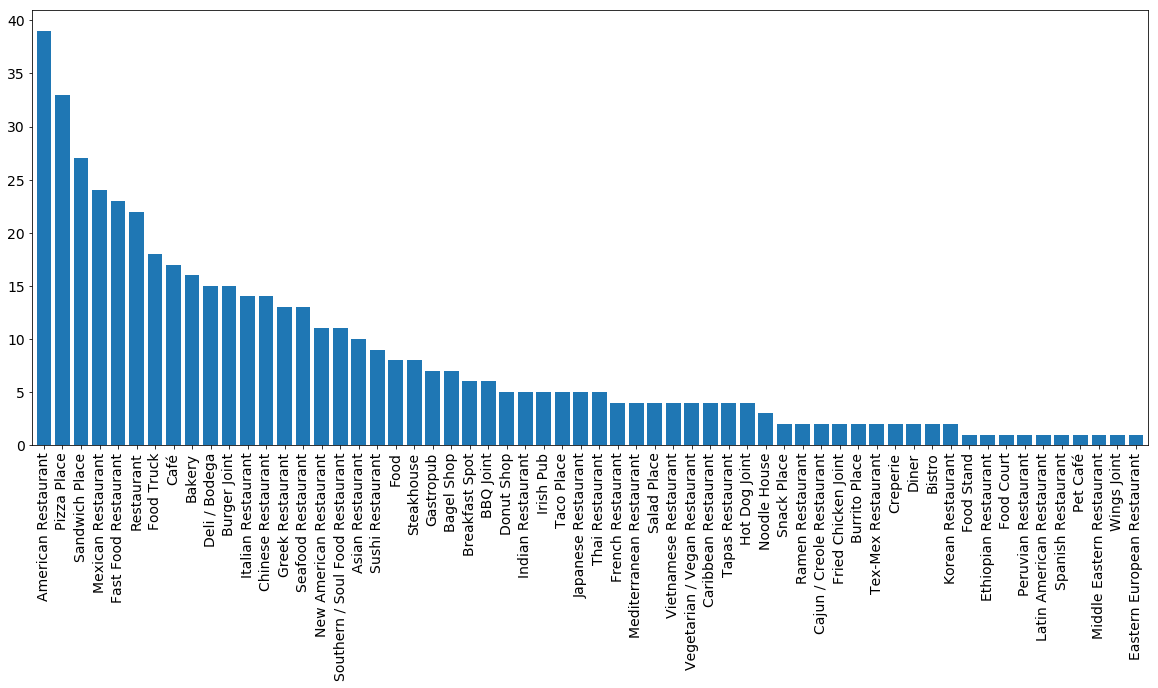

In [17]:
ax = Charlotte_counts.plot(kind='bar', figsize = (20, 8), width = 0.8, fontsize = 14)

In [18]:
# one hot encoding
charlotte_onehot = pd.get_dummies(Charlotte_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
charlotte_onehot['Neighborhood'] = Charlotte_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [charlotte_onehot.columns[-1]] + list(charlotte_onehot.columns[:-1])
charlotte_onehot = charlotte_onehot[fixed_columns]

charlotte_onehot.head()
charlotte_onehot.shape

(481, 61)

In [19]:
charlotte_grouped = charlotte_onehot.groupby('Neighborhood').mean().reset_index()
charlotte_grouped
#charlotte_grouped.shape

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Creperie,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Greek Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Noodle House,Peruvian Restaurant,Pet Café,Pizza Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Ballantyne,0.105263,0.078947,0.026316,0.026316,0.052632,0.000000,0.026316,0.052632,0.00,0.026316,0.000000,0.000000,0.026316,0.00,0.026316,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.026316,0.026316,0.052632,0.000000,0.052632,0.000000,0.000000,0.00000,0.000000,0.052632,0.00,0.000000,0.000000,0.00000,0.00,0.105263,0.026316,0.026316,0.026316,0.026316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.026316,0.000000,0.000000,0.000000,0.026316
1,Biddleville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.400000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.200000,0.000000,0.00,0.000000,0.000000,0.00000,0.00,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Brooklyn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.142857,0.000000,0.000000,0.00,0.00000,0.000000,0.142857,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.071429,0.00,0.000000,0.000000,0.00000,0.00,0.142857,0.000000,0.071429,0.000000,0.000000,0.071429,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Chantilly,0.041667,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.041667,0.00,0.000000,0.000000,0.041667,0.083333,0.00,0.083333,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.041667,0.00,0.000000,0.000000,0.00000,0.00,0.083333,0.000000,0.125000,0.000000,0.041667,0.000000,0.000000,0.083333,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000
4,Cotswold,0.000000,0.000000,0.000000,0.055556,0.055556,0.000000,0.055556,0.055556,0.00,0.055556,0.000000,0.000000,0.055556,0.00,0.000000,0.000000,0.055556,0.00,0.00000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.055556,0.00,0.000000,0.000000,0.00000,0.00,0.166667,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000
5,Coulwood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.333333,0.00,0.000000,0.000000,0.00000,0.00,0.000000,0.

### Find most common Venues for each Neighborhood

In [20]:
num_top_venues = 5

for hood in charlotte_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = charlotte_grouped[charlotte_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ballantyne ----
                 venue  freq
0  American Restaurant  0.11
1          Pizza Place  0.11
2     Asian Restaurant  0.08
3    Indian Restaurant  0.05
4               Bakery  0.05


----Biddleville ----
                      venue  freq
0                      Café   0.4
1  Mediterranean Restaurant   0.2
2       Fried Chicken Joint   0.2
3               Pizza Place   0.2
4       American Restaurant   0.0


----Brooklyn ----
           venue  freq
0           Food  0.14
1    Pizza Place  0.14
2  Deli / Bodega  0.14
3     Restaurant  0.07
4     Food Truck  0.07


----Chantilly ----
                             venue  freq
0                       Restaurant  0.12
1                           Bakery  0.12
2               Chinese Restaurant  0.08
3                      Pizza Place  0.08
4  Southern / Soul Food Restaurant  0.08


----Cotswold ----
                  venue  freq
0  Fast Food Restaurant  0.17
1           Pizza Place  0.17
2    Mexican Restaurant  0.06
3            D

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = charlotte_grouped['Neighborhood']

for ind in np.arange(charlotte_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(charlotte_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ballantyne,American Restaurant,Pizza Place,Asian Restaurant,Bakery,Burger Joint,Food Truck,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Wings Joint
1,Biddleville,Café,Fried Chicken Joint,Mediterranean Restaurant,Pizza Place,Wings Joint,Diner,Gastropub,French Restaurant,Food Truck,Food Stand
2,Brooklyn,Pizza Place,Food,Deli / Bodega,Burger Joint,Food Truck,Food Stand,Taco Place,Restaurant,Southern / Soul Food Restaurant,Mexican Restaurant
3,Chantilly,Bakery,Restaurant,Pizza Place,Deli / Bodega,Chinese Restaurant,Southern / Soul Food Restaurant,Sandwich Place,Greek Restaurant,Food Truck,Vietnamese Restaurant
4,Cotswold,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Breakfast Spot,Mexican Restaurant,Donut Shop,Sandwich Place,Café,Burger Joint,Greek Restaurant


In [23]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ballantyne,American Restaurant,Pizza Place,Asian Restaurant,Bakery,Burger Joint,Food Truck,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Wings Joint
1,Biddleville,Café,Fried Chicken Joint,Mediterranean Restaurant,Pizza Place,Wings Joint,Diner,Gastropub,French Restaurant,Food Truck,Food Stand
2,Brooklyn,Pizza Place,Food,Deli / Bodega,Burger Joint,Food Truck,Food Stand,Taco Place,Restaurant,Southern / Soul Food Restaurant,Mexican Restaurant
3,Chantilly,Bakery,Restaurant,Pizza Place,Deli / Bodega,Chinese Restaurant,Southern / Soul Food Restaurant,Sandwich Place,Greek Restaurant,Food Truck,Vietnamese Restaurant
4,Cotswold,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Breakfast Spot,Mexican Restaurant,Donut Shop,Sandwich Place,Café,Burger Joint,Greek Restaurant
5,Coulwood,Gastropub,Mexican Restaurant,Southern / Soul Food Restaurant,Wings Joint,Deli / Bodega,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court
6,Derita,Southern / Soul Food Restaurant,Wings Joint,Deli / Bodega,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court,Food
7,Dilworth,American Restaurant,BBQ Joint,Food Truck,Mediterranean Restaurant,Food,Fast Food Restaurant,Seafood Restaurant,Diner,Gastropub,Fried Chicken Joint
8,Eastland,Seafood Restaurant,Fast Food Restaurant,Indian Restaurant,Mexican Restaurant,Caribbean Restaurant,Sandwich Place,Chinese Restaurant,Breakfast Spot,Burger Joint,Fried Chicken Joint
9,Elizabeth,Pizza Place,Greek Restaurant,New American Restaurant,Sandwich Place,Fast Food Restaurant,Bakery,Chinese Restaurant,Restaurant,Food,Ethiopian Restaurant


### Setup K-means Clustering for Analysis

In [24]:
# set number of clusters
kclusters = 8

charlotte_grouped_clustering = charlotte_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(charlotte_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 2, 2, 1, 7, 5, 2, 1, 1])

In [25]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

charlotte_merged = charlotte2
#charlotte_merged = downtown_merged.rename(columns = {'Neighbourhood' : 'Neighborhood' })
charlotte_merged.head()
# merge downtown_grouped with downtown_data to add latitude/longitude for each neighborhood
charlotte_merged = charlotte_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

charlotte_merged # check the last columns!

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,The Arboretum,35.097267,-80.781769,1.0,Fast Food Restaurant,Asian Restaurant,Café,Sandwich Place,American Restaurant,Salad Place,Greek Restaurant,Italian Restaurant,Diner,Deli / Bodega
2,Ballantyne,35.054659,-80.850246,2.0,American Restaurant,Pizza Place,Asian Restaurant,Bakery,Burger Joint,Food Truck,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Wings Joint
3,Biddleville,35.245043,-80.857348,1.0,Café,Fried Chicken Joint,Mediterranean Restaurant,Pizza Place,Wings Joint,Diner,Gastropub,French Restaurant,Food Truck,Food Stand
4,Brooklyn,35.224277,-80.825737,2.0,Pizza Place,Food,Deli / Bodega,Burger Joint,Food Truck,Food Stand,Taco Place,Restaurant,Southern / Soul Food Restaurant,Mexican Restaurant
5,Chantilly,35.213754,-80.810071,2.0,Bakery,Restaurant,Pizza Place,Deli / Bodega,Chinese Restaurant,Southern / Soul Food Restaurant,Sandwich Place,Greek Restaurant,Food Truck,Vietnamese Restaurant
6,Uptown Charlotte,35.227190,-80.843083,2.0,American Restaurant,Pizza Place,Mexican Restaurant,Sandwich Place,Steakhouse,Restaurant,Irish Pub,Italian Restaurant,New American Restaurant,Seafood Restaurant
7,Cotswold,35.175924,-80.798330,1.0,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Breakfast Spot,Mexican Restaurant,Donut Shop,Sandwich Place,Café,Burger Joint,Greek Restaurant
8,Coulwood,35.304209,-80.936693,7.0,Gastropub,Mexican Restaurant,Southern / Soul Food Restaurant,Wings Joint,Deli / Bodega,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court
9,Derita,35.286502,-80.811617,5.0,Southern / Soul Food Restaurant,Wings Joint,Deli / Bodega,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court,Food
10,Dilworth,35.209587,-80.847572,2.0,American Restaurant,BBQ Joint,Food Truck,Mediterranean Restaurant,Food,Fast Food Restaurant,Seafood Restaurant,Diner,Gastropub,Fried Chicken Joint


In [26]:
charlotte_final = charlotte_merged.dropna()

In [27]:
charlotte_final["Cluster Labels"] = charlotte_final["Cluster Labels"].astype(int)
charlotte_final

C:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,The Arboretum,35.097267,-80.781769,1,Fast Food Restaurant,Asian Restaurant,Café,Sandwich Place,American Restaurant,Salad Place,Greek Restaurant,Italian Restaurant,Diner,Deli / Bodega
2,Ballantyne,35.054659,-80.850246,2,American Restaurant,Pizza Place,Asian Restaurant,Bakery,Burger Joint,Food Truck,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Wings Joint
3,Biddleville,35.245043,-80.857348,1,Café,Fried Chicken Joint,Mediterranean Restaurant,Pizza Place,Wings Joint,Diner,Gastropub,French Restaurant,Food Truck,Food Stand
4,Brooklyn,35.224277,-80.825737,2,Pizza Place,Food,Deli / Bodega,Burger Joint,Food Truck,Food Stand,Taco Place,Restaurant,Southern / Soul Food Restaurant,Mexican Restaurant
5,Chantilly,35.213754,-80.810071,2,Bakery,Restaurant,Pizza Place,Deli / Bodega,Chinese Restaurant,Southern / Soul Food Restaurant,Sandwich Place,Greek Restaurant,Food Truck,Vietnamese Restaurant
6,Uptown Charlotte,35.227190,-80.843083,2,American Restaurant,Pizza Place,Mexican Restaurant,Sandwich Place,Steakhouse,Restaurant,Irish Pub,Italian Restaurant,New American Restaurant,Seafood Restaurant
7,Cotswold,35.175924,-80.798330,1,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Breakfast Spot,Mexican Restaurant,Donut Shop,Sandwich Place,Café,Burger Joint,Greek Restaurant
8,Coulwood,35.304209,-80.936693,7,Gastropub,Mexican Restaurant,Southern / Soul Food Restaurant,Wings Joint,Deli / Bodega,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court
9,Derita,35.286502,-80.811617,5,Southern / Soul Food Restaurant,Wings Joint,Deli / Bodega,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court,Food
10,Dilworth,35.209587,-80.847572,2,American Restaurant,BBQ Joint,Food Truck,Mediterranean Restaurant,Food,Fast Food Restaurant,Seafood Restaurant,Diner,Gastropub,Fried Chicken Joint


### Create Visualizaion for Clustering

In [28]:
# create map
map_clusters = folium.Map(location=[latitude1, longitude1], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(charlotte_final['Latitude'], charlotte_final['Longitude'], charlotte_final['Neighborhood'], charlotte_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Show values for each cluster

In [29]:
charlotte_final.loc[charlotte_final['Cluster Labels'] == 0, charlotte_final.columns[[0] + list(range(4, charlotte_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Highland Creek,Restaurant,Hot Dog Joint,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court,Food,Fast Food Restaurant


In [30]:
charlotte_final.loc[charlotte_final['Cluster Labels'] == 1, charlotte_final.columns[[0] + list(range(4, charlotte_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,The Arboretum,Fast Food Restaurant,Asian Restaurant,Café,Sandwich Place,American Restaurant,Salad Place,Greek Restaurant,Italian Restaurant,Diner,Deli / Bodega
3,Biddleville,Café,Fried Chicken Joint,Mediterranean Restaurant,Pizza Place,Wings Joint,Diner,Gastropub,French Restaurant,Food Truck,Food Stand
7,Cotswold,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Breakfast Spot,Mexican Restaurant,Donut Shop,Sandwich Place,Café,Burger Joint,Greek Restaurant
11,Eastland,Seafood Restaurant,Fast Food Restaurant,Indian Restaurant,Mexican Restaurant,Caribbean Restaurant,Sandwich Place,Chinese Restaurant,Breakfast Spot,Burger Joint,Fried Chicken Joint
12,Elizabeth,Pizza Place,Greek Restaurant,New American Restaurant,Sandwich Place,Fast Food Restaurant,Bakery,Chinese Restaurant,Restaurant,Food,Ethiopian Restaurant
25,SouthPark,American Restaurant,Sandwich Place,Fast Food Restaurant,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Mexican Restaurant,Café,Steakhouse,Seafood Restaurant


In [31]:
charlotte_final.loc[charlotte_final['Cluster Labels'] == 2, charlotte_final.columns[[0] + list(range(4, charlotte_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Ballantyne,American Restaurant,Pizza Place,Asian Restaurant,Bakery,Burger Joint,Food Truck,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Wings Joint
4,Brooklyn,Pizza Place,Food,Deli / Bodega,Burger Joint,Food Truck,Food Stand,Taco Place,Restaurant,Southern / Soul Food Restaurant,Mexican Restaurant
5,Chantilly,Bakery,Restaurant,Pizza Place,Deli / Bodega,Chinese Restaurant,Southern / Soul Food Restaurant,Sandwich Place,Greek Restaurant,Food Truck,Vietnamese Restaurant
6,Uptown Charlotte,American Restaurant,Pizza Place,Mexican Restaurant,Sandwich Place,Steakhouse,Restaurant,Irish Pub,Italian Restaurant,New American Restaurant,Seafood Restaurant
10,Dilworth,American Restaurant,BBQ Joint,Food Truck,Mediterranean Restaurant,Food,Fast Food Restaurant,Seafood Restaurant,Diner,Gastropub,Fried Chicken Joint
15,Myers Park,Restaurant,Bagel Shop,Food,Deli / Bodega,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court
16,NoDa,Gastropub,Seafood Restaurant,Burger Joint,American Restaurant,Eastern European Restaurant,Donut Shop,Café,Pet Café,Burrito Place,Restaurant
18,Parkdale,American Restaurant,Mexican Restaurant,Italian Restaurant,Food Truck,Vietnamese Restaurant,Bakery,Bistro,Gastropub,Asian Restaurant,Fried Chicken Joint
20,Plaza-Midwood,Restaurant,Pizza Place,Bakery,Food Truck,American Restaurant,Gastropub,Deli / Bodega,Southern / Soul Food Restaurant,Sandwich Place,Greek Restaurant
24,South End,American Restaurant,Deli / Bodega,Pizza Place,Food Truck,Italian Restaurant,Restaurant,Food,Sandwich Place,Korean Restaurant,Donut Shop


In [32]:
charlotte_final.loc[charlotte_final['Cluster Labels'] == 3, charlotte_final.columns[[0] + list(range(4, charlotte_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,University City,American Restaurant,New American Restaurant,Hot Dog Joint,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court,Food


In [33]:
charlotte_final.loc[charlotte_final['Cluster Labels'] == 4, charlotte_final.columns[[0] + list(range(4, charlotte_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Mountain Island,Food Truck,Café,Vietnamese Restaurant,Wings Joint,Diner,Greek Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Stand
27,Steele Creek,Food Truck,Wings Joint,Vietnamese Restaurant,Greek Restaurant,Gastropub,Fried Chicken Joint,French Restaurant,Food Stand,Food Court,Food


In [34]:
charlotte_final.loc[charlotte_final['Cluster Labels'] == 5, charlotte_final.columns[[0] + list(range(4, charlotte_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Derita,Southern / Soul Food Restaurant,Wings Joint,Deli / Bodega,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court,Food


In [35]:
charlotte_final.loc[charlotte_final['Cluster Labels'] == 6, charlotte_final.columns[[0] + list(range(4, charlotte_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Sedgefield,Fast Food Restaurant,American Restaurant,Food,Sandwich Place,Deli / Bodega,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand
26,Starmount,Fast Food Restaurant,Mexican Restaurant,Wings Joint,Hot Dog Joint,Gastropub,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court


In [36]:
charlotte_final.loc[charlotte_final['Cluster Labels'] == 7, charlotte_final.columns[[0] + list(range(4, charlotte_final.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Coulwood,Gastropub,Mexican Restaurant,Southern / Soul Food Restaurant,Wings Joint,Deli / Bodega,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand,Food Court
